# MNIST Point Cloud Classification

This task attempts to classify a set of 2D-points in the shape of a number. Using the MNIST dataset, point clouds are generated with a random number of points.

Note: the datasets are not included in this repository. Instead, they need to be generated using the [MNIST Point Cloud](https://github.com/DLii-Research/mnist-pointcloud) library.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import settransformer

2021-10-11 13:07:48.297712: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Strategy

Grab the appropriate compute device(s).

In [2]:
DEVICE = "gpu:0"
MULTI_GPU = False

In [4]:
if MULTI_GPU:
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.OneDeviceStrategy(DEVICE)

---
## 100-Element Point Clouds

In [7]:
# Point Clouds
with np.load("./datasets/mnist_point_cloud_train_100.npz") as f:
    x_train = f[list(f.keys())[0]]
    
with np.load("./datasets/mnist_point_cloud_test_100.npz") as f:
    x_test = f[list(f.keys())[0]]

# Labels
(_, y_train_labels), (_, y_test_labels) = keras.datasets.mnist.load_data()

# One-hot encoded labels
y_train = np.zeros((y_train_labels.size, y_train_labels.max()+1))
y_train[np.arange(y_train_labels.size), y_train_labels] = 1
y_test = np.zeros((y_test_labels.size, y_test_labels.max()+1))
y_test[np.arange(y_test_labels.size), y_test_labels] = 1

_ = None # Free memory

In [8]:
x_train.shape, x_test.shape

((60000, 100, 2), (10000, 100, 2))

In [9]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

### Model Architecture

In [14]:
class PointCloudSetTransformer(keras.models.Model):
    def __init__(self, embed_dim=64, num_induce=32, num_heads=4):
        super(PointCloudSetTransformer, self).__init__()
        
        # Encoder
        inp = keras.layers.Input((None, 2))
        out = keras.layers.Dense(embed_dim)(inp)
        out = settransformer.InducedSetAttentionBlock(embed_dim, num_heads, num_induce)(out)
        out = settransformer.InducedSetAttentionBlock(embed_dim, num_heads, num_induce)(out)
        self.encoder = keras.models.Model(inp, out)
        
        # Decoder
        inp = keras.layers.Input((None, embed_dim))
        out = keras.layers.Dropout(0.5)(inp)
        out = settransformer.PoolingByMultiHeadAttention(1, embed_dim, 1)(out)
        out = keras.layers.Dropout(0.5)(out)
        out = keras.layers.Dense(10)(out)
        self.decoder = keras.models.Model(inp, out)
        
    def call(self, x):
        return tf.squeeze(self.decoder(self.encoder(x)))

In [17]:
with strategy.scope():
    model = PointCloudSetTransformer()
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )

In [18]:
model(x_train[:1])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.6428387 ,  0.43179658, -0.5398211 ,  1.3523539 ,  0.19612105,
       -0.06450772, -0.93190545, -1.5174229 ,  2.4128482 , -1.1353003 ],
      dtype=float32)>

### Training

In [19]:
with strategy.scope():
    history = model.fit(x_train, y_train_labels, validation_split=0.2, epochs=20)

2021-10-11 12:45:20.798051: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_106019"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

Epoch 1/20
1496/1500 [============================>.] - ETA: 0s - loss: 1.8497 - sparse_categorical_accuracy: 0.3280

2021-10-11 12:45:39.236698: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_113220"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

1500/1500 [==============================] - 20s 12ms/step - loss: 1.8472 - sparse_categorical_accuracy: 0.3289 - val_loss: 0.8193 - val_sparse_categorical_accuracy: 0.7329
Epoch 2/20
1500/1500 [==============================] - 17s 12ms/step - loss: 0.7778 - sparse_categorical_accuracy: 0.7389 - val_loss: 0.6083 - val_sparse_categorical_accuracy: 0.8027
Epoch 3/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.5865 - sparse_categorical_accuracy: 0.8096 - val_loss: 0.4084 - val_sparse_categorical_accuracy: 0.8637
Epoch 4/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.4647 - sparse_categorical_accuracy: 0.8529 - val_loss: 0.3218 - val_sparse_categorical_accuracy: 0.8957
Epoch 5/20
1500/1500 [==============================] - 17s 12ms/step - loss: 0.3846 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.2578 - val_sparse_categorical_accuracy: 0.9197
Epoch 6/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.3356 - spar

In [20]:
with strategy.scope():
    model.evaluate(x_test, y_test_labels, batch_size=1)

2021-10-11 12:51:14.671247: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_187063"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Auto

10000/10000 [==============================] - 46s 5ms/step - loss: 0.1953 - sparse_categorical_accuracy: 0.9395


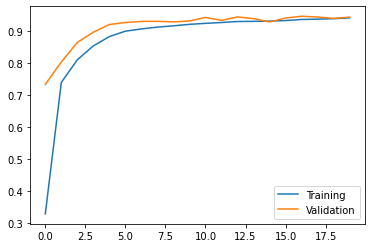

In [21]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.legend(["Training", "Validation"])
plt.show()

---
## 1000-Element Point Clouds

In [19]:
# Point Clouds
with np.load("./datasets/mnist_point_cloud_train_1000.npz") as f:
    x_train = f[list(f.keys())[0]]
    
with np.load("./datasets/mnist_point_cloud_test_1000.npz") as f:
    x_test = f[list(f.keys())[0]]

# Labels
(_, y_train_labels), (_, y_test_labels) = keras.datasets.mnist.load_data()

# One-hot encoded labels
y_train = np.zeros((y_train_labels.size, y_train_labels.max()+1))
y_train[np.arange(y_train_labels.size), y_train_labels] = 1
y_test = np.zeros((y_test_labels.size, y_test_labels.max()+1))
y_test[np.arange(y_test_labels.size), y_test_labels] = 1

_ = None # Free memory

In [20]:
x_train.shape, x_test.shape

((60000, 1000, 2), (10000, 1000, 2))

In [21]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

### Model

In [22]:
with strategy.scope():
    model = PointCloudSetTransformer()
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )

In [23]:
model.encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, 2)]         0         
_________________________________________________________________
dense_16 (Dense)             (None, None, 64)          192       
_________________________________________________________________
induced_set_attention_block_ (None, None, 64)          143616    
_________________________________________________________________
induced_set_attention_block_ (None, None, 64)          143616    
Total params: 287,424
Trainable params: 287,424
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None, 64)]        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
pooling_by_multi_head_attent (None, 1, 64)             21120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 1, 10)             650       
Total params: 21,770
Trainable params: 21,770
Non-trainable params: 0
_________________________________________________________________


In [25]:
model(x_train[:1])

2021-10-11 13:10:01.537753: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-11 13:10:01.748815: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.649069  , -1.5614321 ,  1.9313924 ,  1.334004  , -0.8865581 ,
        1.083253  , -0.50958705, -0.33919162, -3.3516853 , -0.31087857],
      dtype=float32)>

### Training

In [26]:
with strategy.scope():
    history = model.fit(x_train, y_train_labels, validation_split=0.2, epochs=20)

2021-10-11 13:10:23.668417: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 384000000 exceeds 10% of free system memory.
2021-10-11 13:10:23.825302: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 384000000 exceeds 10% of free system memory.
2021-10-11 13:10:24.036395: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3901"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    

Epoch 1/20
1500/1500 [==============================] - ETA: 0s - loss: 2.0378 - sparse_categorical_accuracy: 0.2487

2021-10-11 13:11:47.740000: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_11102"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Auto

1500/1500 [==============================] - 90s 59ms/step - loss: 2.0378 - sparse_categorical_accuracy: 0.2487 - val_loss: 1.2632 - val_sparse_categorical_accuracy: 0.5710
Epoch 2/20
1500/1500 [==============================] - 87s 58ms/step - loss: 0.8262 - sparse_categorical_accuracy: 0.7245 - val_loss: 0.6900 - val_sparse_categorical_accuracy: 0.7671
Epoch 3/20
1500/1500 [==============================] - 88s 59ms/step - loss: 0.4832 - sparse_categorical_accuracy: 0.8489 - val_loss: 0.3782 - val_sparse_categorical_accuracy: 0.8792
Epoch 4/20
1500/1500 [==============================] - 86s 57ms/step - loss: 0.3466 - sparse_categorical_accuracy: 0.8947 - val_loss: 0.3095 - val_sparse_categorical_accuracy: 0.8954
Epoch 5/20
1500/1500 [==============================] - 88s 59ms/step - loss: 0.2760 - sparse_categorical_accuracy: 0.9169 - val_loss: 0.2348 - val_sparse_categorical_accuracy: 0.9314
Epoch 6/20
1500/1500 [==============================] - 87s 58ms/step - loss: 0.2342 - spar

In [27]:
with strategy.scope():
    model.evaluate(x_test, y_test_labels, batch_size=1)

2021-10-11 13:43:36.582444: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_84945"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = AutoS

10000/10000 [==============================] - 45s 4ms/step - loss: 0.1178 - sparse_categorical_accuracy: 0.9662


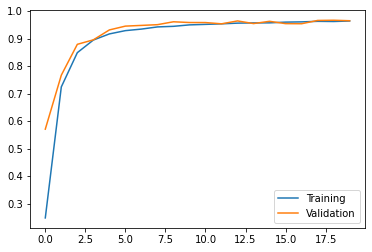

In [28]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.legend(["Training", "Validation"])
plt.show()